# Image Classification


## **Import library & Data Gathering**

In [1]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
from tqdm import tqdm
from collections import defaultdict

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers, regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet, MobileNetV2
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from keras.layers import TFSMLayer

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

**Files upload: user harus mengupload kaggle.json yang berisi API token**

In [2]:
!pip install kaggle  # Install Kaggle API jika belum terpasang

# Upload file kaggle.json yang berisi API token ke direktori kerja
from google.colab import files
files.upload()

# Pindahkan file kaggle.json ke direktori yang tepat
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Ubah izin file agar dapat dibaca
!chmod 600 ~/.kaggle/kaggle.json

# Unduh dataset
!kaggle datasets download -d marquis03/plants-classification

# Ekstrak file zip
!unzip plants-classification.zip -d plants_classification


Streaming output truncated to the last 5000 lines.
  inflating: plants_classification/train/tobacco/tobacco190.jpg  
  inflating: plants_classification/train/tobacco/tobacco191.jpg  
  inflating: plants_classification/train/tobacco/tobacco192.jpg  
  inflating: plants_classification/train/tobacco/tobacco193.jpg  
  inflating: plants_classification/train/tobacco/tobacco194.jpg  
  inflating: plants_classification/train/tobacco/tobacco195.jpg  
  inflating: plants_classification/train/tobacco/tobacco196.jpg  
  inflating: plants_classification/train/tobacco/tobacco197.jpg  
  inflating: plants_classification/train/tobacco/tobacco198.jpg  
  inflating: plants_classification/train/tobacco/tobacco199.jpg  
  inflating: plants_classification/train/tobacco/tobacco2.jpg  
  inflating: plants_classification/train/tobacco/tobacco20.jpg  
  inflating: plants_classification/train/tobacco/tobacco200.jpg  
  inflating: plants_classification/train/tobacco/tobacco201.jpg  
  inflating: plants_classifi

**Menggabungkan folder train, test, dan val menjadi satu folder baru yaitu plants_dataset**<br>
Folder 'plants_dataset' memiliki 30 folder nama-nama tanaman. Dan di dalamnya terdapat 1000 file gambar masing-masing tanaman.

## **Data Preparation**


In [3]:
# Direktori asal dataset: train, test, dan valid
train_dir = "plants_classification/train"
test_dir = "plants_classification/test"
valid_dir = "plants_classification/val"

# Direktori tujuan untuk menggabungkan semua data
combined_dir = "plants_dataset"

# Membuat folder gabungan jika belum ada
os.makedirs(combined_dir, exist_ok=True)

# Menggabungkan data dari folder train
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Menggabungkan data dari folder test
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Menggabungkan data dari folder valid
for category in os.listdir(valid_dir):
    category_dir = os.path.join(valid_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

print("Data berhasil digabung ke dalam:", combined_dir)


Data berhasil digabung ke dalam: plants_dataset


**Menampilkan banyak nya isi dalam folder 'plants_dataset'**<br>
df_distribution berisi image path, label, dan nama image tersebut

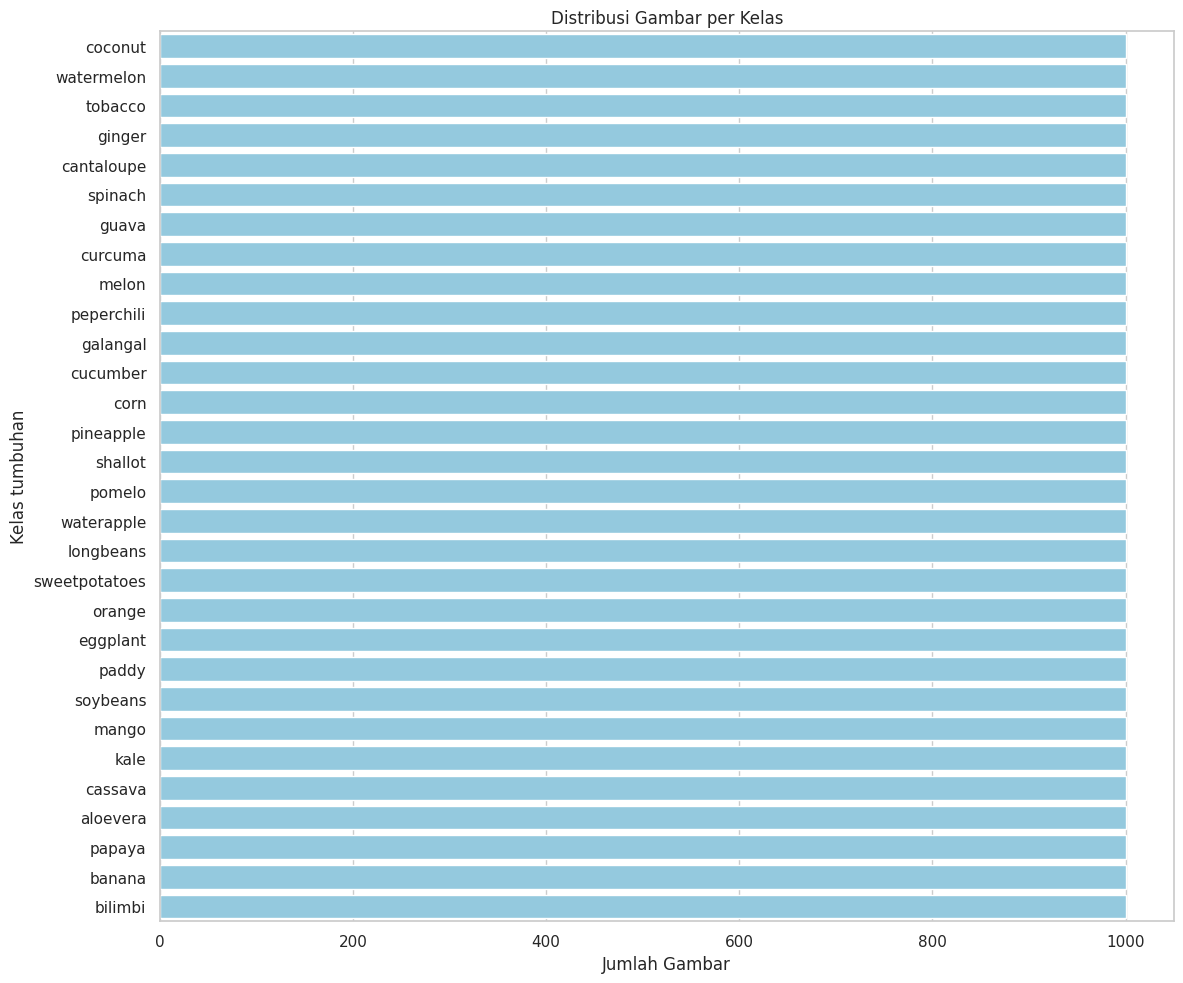

Total file dalam folder 'plants_dataset': 30000 files


In [4]:
# Set path ke dataset utama
dataset_path = "plants_dataset"

# List untuk menyimpan data gambar
image_paths = []
image_labels = []
image_names = []

# Untuk menjelajahi setiap direktori dan file dalam dataset
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(root, file))
            image_labels.append(os.path.basename(root))
            image_names.append(file)

# Membuat DataFrame dari hasil eksplorasi direktori
df_distribution = pd.DataFrame({
    "file_path": image_paths,
    "file_name": image_names,
    "label": image_labels
})

# Menghitung jumlah gambar per label, urutkan dari terbanyak
label_counts = df_distribution['label'].value_counts().sort_values(ascending=True)
total_counts = df_distribution['label'].value_counts().sum()

# Plot horizontal bar chart
plt.figure(figsize=(12, 10))
sns.set_theme(style="whitegrid")
sns.barplot(x=label_counts.values, y=label_counts.index, color='skyblue')
plt.title("Distribusi Gambar per Kelas")
plt.xlabel("Jumlah Gambar")
plt.ylabel("Kelas tumbuhan")
plt.tight_layout()
plt.show()

print(f"Total file dalam folder '{dataset_path}': {total_counts} files")


**Karena dalam satu folder saya rasa terlalu banyak (30 kelas), maka dari itu saya potong dataset menjadi hanya 5 kelas saja.**<br>
Dibuat dataframe baru yaitu newdataset yang berisikan 5 kelas saja.

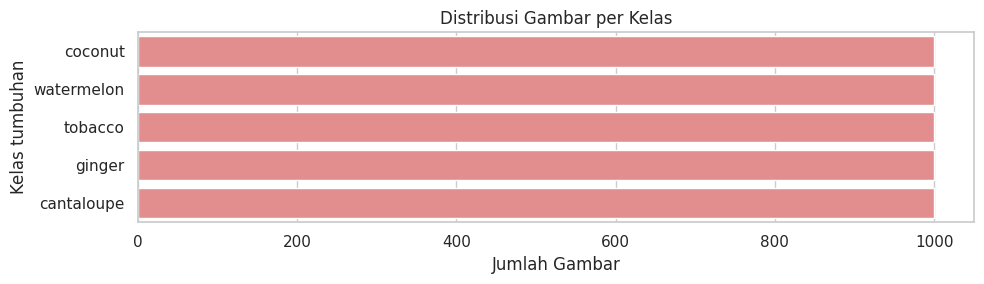

Total file dalam folder 'plants_dataset' setelah dipotong: 5000 files


In [5]:
# Ambil 5 label terbanyak karena saya hanya ingin identifikasi 12 kelas saja
top_5_labels = label_counts.sort_values(ascending=False).head(5).index.tolist()

# Filter DataFrame hanya untuk 5 label tersebut
newdataset = df_distribution[df_distribution['label'].isin(top_5_labels)].reset_index(drop=True)
newdataset

# Menghitung jumlah gambar per label, urutkan dari terbanyak
label_counts = newdataset['label'].value_counts().sort_values(ascending=True)
total_counts = newdataset['label'].value_counts().sum()

# Plot horizontal bar chart
plt.figure(figsize=(10, 3))
sns.set_theme(style="whitegrid")
sns.barplot(x=label_counts.values, y=label_counts.index, color='lightcoral')
plt.title("Distribusi Gambar per Kelas")
plt.xlabel("Jumlah Gambar")
plt.ylabel("Kelas tumbuhan")
plt.tight_layout()
plt.show()

print(f"Total file dalam folder '{dataset_path}' setelah dipotong: {total_counts} files")

**Membuat folder baru yang berisikan hanya 5 kelas dan 5000 foto dengan nama folder newplants_dataset**

In [6]:
# Buat folder utama baru
new_folder = "newplants_dataset"
os.makedirs(new_folder, exist_ok=True)

# Salin file dari DataFrame 'newdataset' ke folder baru
for _, row in newdataset.iterrows():
    src_path = row['file_path']
    label = row['label']
    dst_dir = os.path.join(new_folder, label)

    os.makedirs(dst_dir, exist_ok=True)  # Buat subfolder per label jika belum ada

    dst_path = os.path.join(dst_dir, row['file_name'])
    shutil.copy2(src_path, dst_path)  # Salin file ke folder baru

print(f"Dataset baru berhasil dibuat di folder '{new_folder}'.")


Dataset baru berhasil dibuat di folder 'newplants_dataset'.


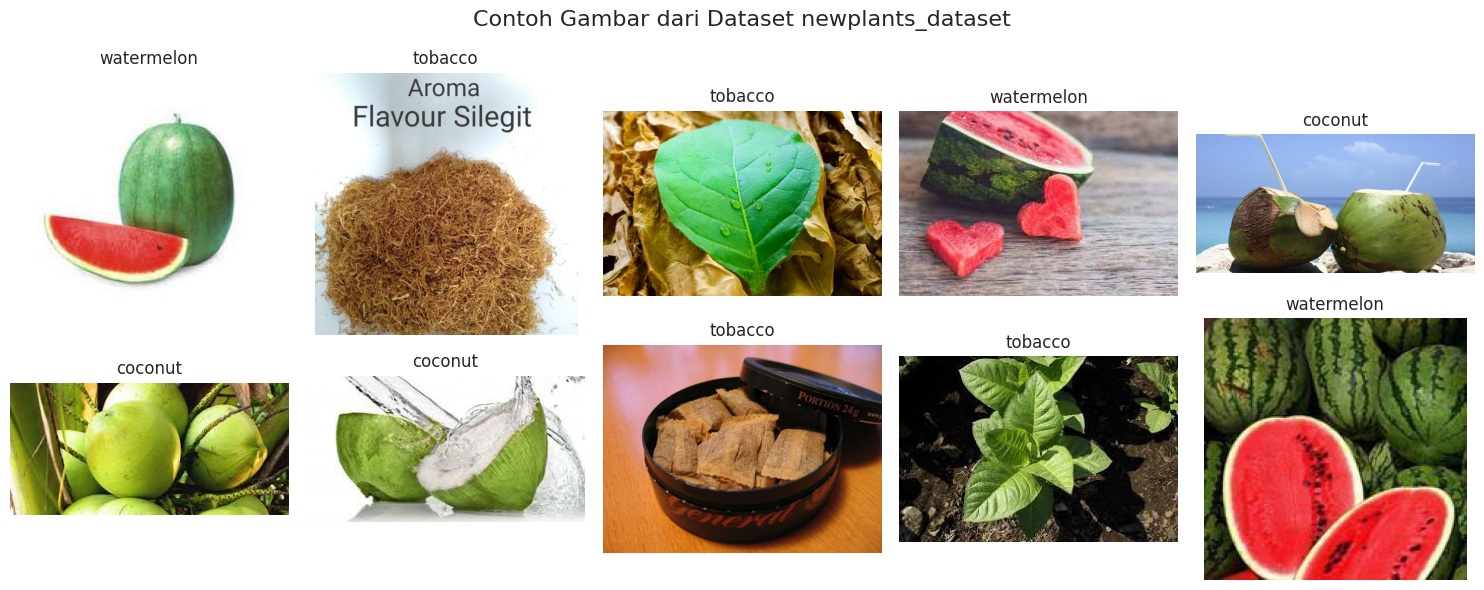

In [7]:
# Menampilkan 10 gambar acak dari newdataset
sample_data = newdataset.sample(10, random_state=42).reset_index(drop=True)

plt.figure(figsize=(15, 6))
for i in range(10):
    img = Image.open(sample_data.loc[i, 'file_path'])
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(sample_data.loc[i, 'label'])
    plt.axis("off")

plt.suptitle("Contoh Gambar dari Dataset newplants_dataset", fontsize=16)
plt.tight_layout()
plt.show()


## **Data Augmentation**

**Data diaugmentasikan (transform) agar nantinya machine learning dapat belajar dari banyak image.**

In [8]:
# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, sudut)

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, -sudut)

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return np.flipud(img)

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    img = adjust_gamma(img, gamma=0.5,gain=1)
    return img

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (9,9),0)

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(translation=(0,40))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image

In [9]:
from skimage.transform import rotate, warp, AffineTransform
from skimage.exposure import adjust_gamma
import numpy as np
from tqdm import tqdm

# Fungsi augmentasi (gunakan yang sudah kamu definisikan sebelumnya)
# Pastikan semua fungsi seperti anticlockwise_rotation, etc. sudah tersedia

# Daftar fungsi augmentasi
augment_functions = [
    anticlockwise_rotation,
    clockwise_rotation,
    flip_up_down,
    add_brightness,
    blur_image,
    sheared,
    warp_shift
]

# Daftar folder yang ingin diaugmentasi
target_labels = ['cantaloupe', 'coconut', 'ginger', 'tobacco', 'watermelon']

# Fungsi untuk augmentasi hanya folder tertentu
def augment_selected_folders(source_folder, destination_folder, selected_labels, augment_count=3):
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    for label in selected_labels:
        label_folder = os.path.join(source_folder, label)
        save_label_folder = os.path.join(destination_folder, label)
        os.makedirs(save_label_folder, exist_ok=True)

        for img_name in tqdm(os.listdir(label_folder), desc=f"Augmenting {label}"):
            img_path = os.path.join(label_folder, img_name)
            img = cv2.imread(img_path)

            if img is None:
                continue

            # Simpan gambar asli
            img_resized = cv2.resize(img, (224, 224))
            cv2.imwrite(os.path.join(save_label_folder, img_name), img_resized)

            # Simpan hasil augmentasi
            for i in range(augment_count):
                func = random.choice(augment_functions)
                aug_img = func(img)
                aug_img = (aug_img * 255).astype(np.uint8)  # Jika pakai skimage
                aug_img_name = f"{os.path.splitext(img_name)[0]}_aug{i}.jpg"
                cv2.imwrite(os.path.join(save_label_folder, aug_img_name), aug_img)

# Panggil fungsi dengan path dataset kamu
source_path = '/content/newplants_dataset'
augmented_path = '/content/augmented_newplants_dataset'
augment_selected_folders(source_path, augmented_path, target_labels, augment_count=3)


Augmenting watermelon: 100%|██████████| 1000/1000 [00:17<00:00, 56.66it/s]


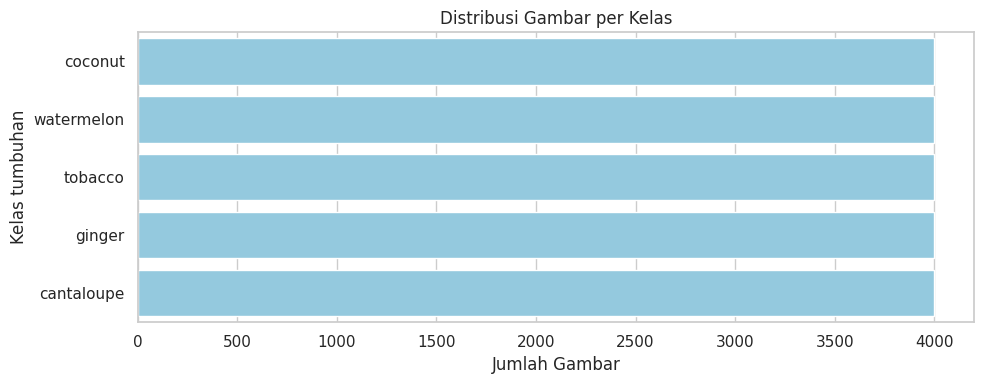

Total file dalam folder 'augmented_newplants_dataset': 20000 files


In [10]:
# Set path ke dataset utama
augmented_path = "augmented_newplants_dataset"

# List untuk menyimpan data gambar
image_paths = []
image_labels = []
image_names = []

# Untuk menjelajahi setiap direktori dan file dalam dataset
for root, dirs, files in os.walk(augmented_path):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(root, file))
            image_labels.append(os.path.basename(root))
            image_names.append(file)

# Membuat DataFrame dari hasil eksplorasi direktori
df_augmented = pd.DataFrame({
    "file_path": image_paths,
    "file_name": image_names,
    "label": image_labels
})

# Menghitung jumlah gambar per label, urutkan dari terbanyak
label_counts = df_augmented['label'].value_counts().sort_values(ascending=True)
total_counts = df_augmented['label'].value_counts().sum()

# Plot horizontal bar chart
plt.figure(figsize=(10, 4))
sns.set_theme(style="whitegrid")
sns.barplot(x=label_counts.values, y=label_counts.index, color='skyblue')
plt.title("Distribusi Gambar per Kelas")
plt.xlabel("Jumlah Gambar")
plt.ylabel("Kelas tumbuhan")
plt.tight_layout()
plt.show()

print(f"Total file dalam folder '{augmented_path}': {total_counts} files")


## **Data Splitting**

**Data splitting dibagi menjadi data training, data testing, dan data validation**<br>
* Data training: 14000 <br>
* Data testing: 3000 <br>
* Data validasi: 3000

In [11]:
def split_data(source_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=42):
    assert train_ratio + val_ratio + test_ratio == 1.0, "Rasio harus berjumlah 1.0"
    random.seed(seed)

    # Buat folder output (Train/Test/Valid)
    for split in ['Train', 'valid', 'test']:
        os.makedirs(os.path.join(output_dir, split), exist_ok=True)

    # Untuk setiap kelas
    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = os.listdir(class_path)
        random.shuffle(images)

        total = len(images)
        train_cutoff = int(train_ratio * total)
        val_cutoff = int((train_ratio + val_ratio) * total)

        splits = {
            'Train': images[:train_cutoff],
            'valid': images[train_cutoff:val_cutoff],
            'test': images[val_cutoff:]
        }

        for split, files in splits.items():
            split_class_dir = os.path.join(output_dir, split, class_name)
            os.makedirs(split_class_dir, exist_ok=True)
            for file in tqdm(files, desc=f"Copying {split}/{class_name}"):
                src_file = os.path.join(class_path, file)
                dst_file = os.path.join(split_class_dir, file)
                shutil.copy2(src_file, dst_file)

In [12]:
source_dataset = '/content/augmented_newplants_dataset'
output_dataset = '/content/split_augmented_dataset'

split_data(source_dataset, output_dataset)

Copying test/cantaloupe: 100%|██████████| 600/600 [00:00<00:00, 5858.16it/s]


In [13]:
def count_files_in_directory(directory):
    total_files = 0
    for root, dirs, files in os.walk(directory):
        total_files += len([f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    return total_files

# Hitung total file di keseluruhan folder
base_dir = '/content/split_augmented_dataset'
total = count_files_in_directory(base_dir)
print(f"Total file dalam dataset ter-split: {total} files")

# Hitung per bagian: Train, Valid, Test
for subset in ['Train', 'valid', 'test']:
    subset_path = os.path.join(base_dir, subset)
    count = count_files_in_directory(subset_path)
    print(f"Jumlah file di {subset}: {count} files")


Total file dalam dataset ter-split: 20000 files
Jumlah file di Train: 14000 files
Jumlah file di valid: 3000 files
Jumlah file di test: 3000 files


## **Image Data Generator**


In [14]:
# ImageDataGenerator untuk normalisasi (rescale pixel dari 0-255 menjadi 0-1)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Set path ke masing-masing subset
train_dir = '/content/split_augmented_dataset/Train'
valid_dir = '/content/split_augmented_dataset/valid'
test_dir = '/content/split_augmented_dataset/test'

# Membuat generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # untuk evaluasi dan prediksi lebih teratur
)


Found 14000 images belonging to 5 classes.
Found 3000 images belonging to 5 classes.
Found 3000 images belonging to 5 classes.


In [15]:
print("Jumlah batch dalam training:", len(train_generator))
print("Jumlah batch dalam validation:", len(valid_generator))
print("Jumlah batch dalam testing:", len(test_generator))


Jumlah batch dalam training: 438
Jumlah batch dalam validation: 94
Jumlah batch dalam testing: 94


## **Modelling**

In [16]:
# Mendapatkan jumlah kelas dari train_generator
num_classes = train_generator.num_classes

# Membuat model CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')  # output sesuai jumlah kelas
])

# Kompilasi model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Menampilkan ringkasan arsitektur model
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,246,853 (84.87 MB)

 Trainable params: 22,246,405 (84.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [17]:
class StopAtAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, target_acc=0.95):
        super(StopAtAccuracy, self).__init__()
        self.target_acc = target_acc

    def on_epoch_end(self, epoch, logs=None):
        # Memeriksa apakah val_accuracy >= target_acc
        val_accuracy = logs.get('val_accuracy')
        if val_accuracy is not None and val_accuracy >= self.target_acc:
            print(f"\nTarget accuracy reached: {val_accuracy:.4f}. Stopping training...")
            self.model.stop_training = True

In [18]:
# Custom callback untuk menghentikan pelatihan jika mencapai 90% akurasi
stop_at_90 = StopAtAccuracy(target_acc=0.95)

# ModelCheckpoint untuk menyimpan model terbaik berdasarkan val_accuracy
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Fit model dengan callbacks
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=15,
    callbacks=[stop_at_90, checkpoint]  # Menggunakan custom callback dan checkpoint
)


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4538 - loss: 2.1706
Epoch 1: val_accuracy improved from -inf to 0.31767, saving model to best_model.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 50s 90ms/step - accuracy: 0.4539 - loss: 2.1690 - val_accuracy: 0.3177 - val_loss: 3.0436
Epoch 2/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6566 - loss: 0.9197
Epoch 2: val_accuracy improved from 0.31767 to 0.73567, saving model to best_model.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - accuracy: 0.6567 - loss: 0.9197 - val_accuracy: 0.7357 - val_loss: 0.7613
Epoch 3/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7216 - loss: 0.7394
Epoch 3: val_accuracy improved from 0.73567 to 0.77833, saving model to best_model.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 42s 73ms/step - accuracy: 0.7216 - loss: 0.7394 - val_accuracy: 0.7783 - val_loss: 0.6519
Epoch 4/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7666 - loss: 0.6322
Epoch 4: val_accuracy improved from 0.77833 to 0.79233, saving model to best_model.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - accuracy: 0.7666 - loss: 0.6322 - val_accuracy: 0.7923 - val_loss: 0.6412
Epoch 5/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8158 - loss: 0.4905
Epoch 5: val_accuracy improved from 0.79233 to 0.81233, saving model to best_model.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 32s 72ms/step - accuracy: 0.8158 - loss: 0.4906 - val_accuracy: 0.8123 - val_loss: 0.5834
Epoch 6/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8435 - loss: 0.4288
Epoch 6: val_accuracy improved from 0.81233 to 0.82433, saving model to best_model.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 70ms/step - accuracy: 0.8435 - loss: 0.4288 - val_accuracy: 0.8243 - val_loss: 0.5526
Epoch 7/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8617 - loss: 0.3789
Epoch 7: val_accuracy did not improve from 0.82433
438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 69ms/step - accuracy: 0.8617 - loss: 0.3789 - val_accuracy: 0.8077 - val_loss: 0.6171
Epoch 8/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8837 - loss: 0.3132
Epoch 8: val_accuracy did not improve from 0.82433
438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 69ms/step - accuracy: 0.8837 - loss: 0.3133 - val_accuracy: 0.8157 - val_loss: 0.6304
Epoch 9/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8877 - loss: 0.3103
Epoch 9: val_accuracy improved from 0.82433 to 0.83033, saving model to best_model.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 37s 85ms/step - accuracy: 0.8877 - loss: 0.3103 - val_accuracy: 0.8303 - val_loss: 0.5516
Epoch 10/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9129 - loss: 0.2468
Epoch 10: val_accuracy improved from 0.83033 to 0.85267, saving model to best_model.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 32s 74ms/step - accuracy: 0.9128 - loss: 0.2468 - val_accuracy: 0.8527 - val_loss: 0.5109
Epoch 11/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9156 - loss: 0.2296
Epoch 11: val_accuracy did not improve from 0.85267
438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 68ms/step - accuracy: 0.9156 - loss: 0.2297 - val_accuracy: 0.8517 - val_loss: 0.5628
Epoch 12/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9309 - loss: 0.1928
Epoch 12: val_accuracy did not improve from 0.85267
438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 69ms/step - accuracy: 0.9308 - loss: 0.1929 - val_accuracy: 0.8493 - val_loss: 0.5763
Epoch 13/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9244 - loss: 0.2065
Epoch 13: val_accuracy did not improve from 0.85267
438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 70ms/step - accuracy: 0.9244 - loss: 0.2065 - val_accuracy: 0.8527 - val_loss: 0.5475
Epoch 14/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9329 - loss: 0.1783
Epoch 14: val_ac

438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - accuracy: 0.9329 - loss: 0.1783 - val_accuracy: 0.8550 - val_loss: 0.6455
Epoch 15/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9433 - loss: 0.1526
Epoch 15: val_accuracy improved from 0.85500 to 0.86567, saving model to best_model.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - accuracy: 0.9433 - loss: 0.1526 - val_accuracy: 0.8657 - val_loss: 0.5554


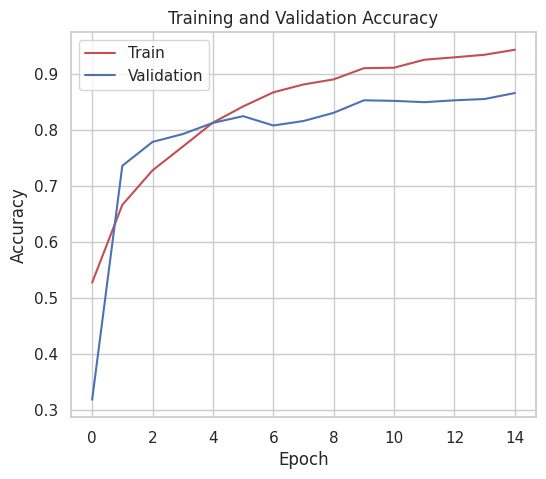

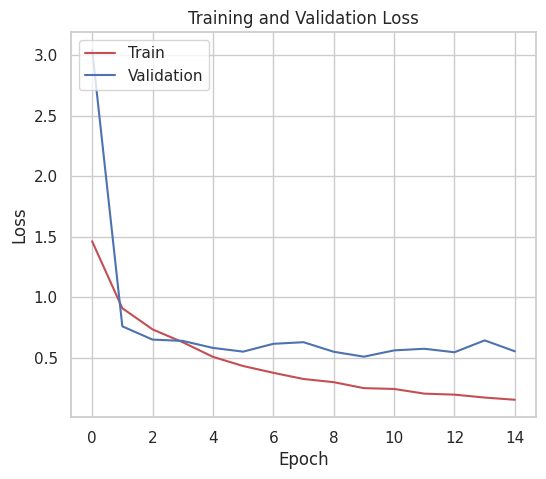

In [19]:
import matplotlib.pyplot as plt

# Retrieve history values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Plot Accuracy
plt.figure(figsize=(6,5))  # Fixed the figure size syntax
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot Loss
plt.figure(figsize=(6,5))  # Fixed the figure size syntax
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and Validation Loss')  # Fixed the title typo
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step
Classification Report:

              precision    recall  f1-score   support

  cantaloupe       0.85      0.81      0.83       600
     coconut       0.83      0.89      0.86       600
      ginger       0.86      0.84      0.85       600
     tobacco       0.82      0.87      0.84       600
  watermelon       0.94      0.88      0.91       600

    accuracy                           0.86      3000
   macro avg       0.86      0.86      0.86      3000
weighted avg       0.86      0.86      0.86      3000



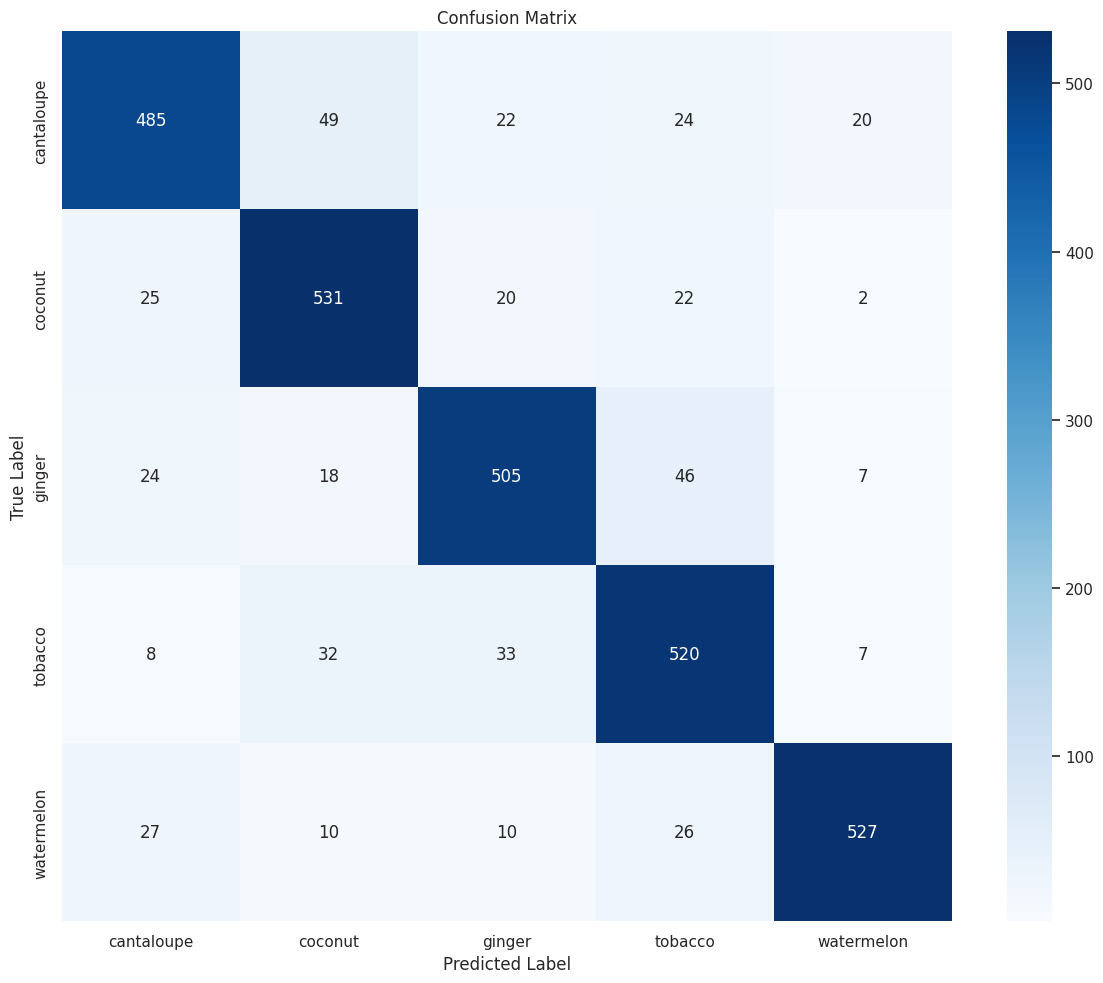

In [20]:
# Prediksi kelas
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Nilai sebenarnya
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

## **Konversi Model**

### Saved_model

In [23]:
model.export('saved_model')

from google.colab import files
import shutil

# Kompres folder saved_model jadi .zip
shutil.make_archive('saved_model', 'zip', 'saved_model')
files.download('saved_model.zip')

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  134522417455632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134522417458128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134522417458704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134522417458320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134522417455248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134522417457936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134522417455056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134522417457744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134522370947984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134522370948752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134522370947600: Te

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### TFLite

In [24]:
# Konversi model ke format TFLite
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
tflite_model = converter.convert()

# Simpan model TFLite sebagai file .tflite
tflite_model_path = "model.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

### TFJS

In [25]:
!pip install tensorflowjs

# Konversi model dari folder 'saved_model' ke folder 'tfjs_model'
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    saved_model \
    tfjs_model

shutil.make_archive('tfjs_model', 'zip', 'tfjs_model')
files.download('tfjs_model.zip')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
2025-04-30 14:56:21.118491: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746024981.138540   10052 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:174

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Inferensi**

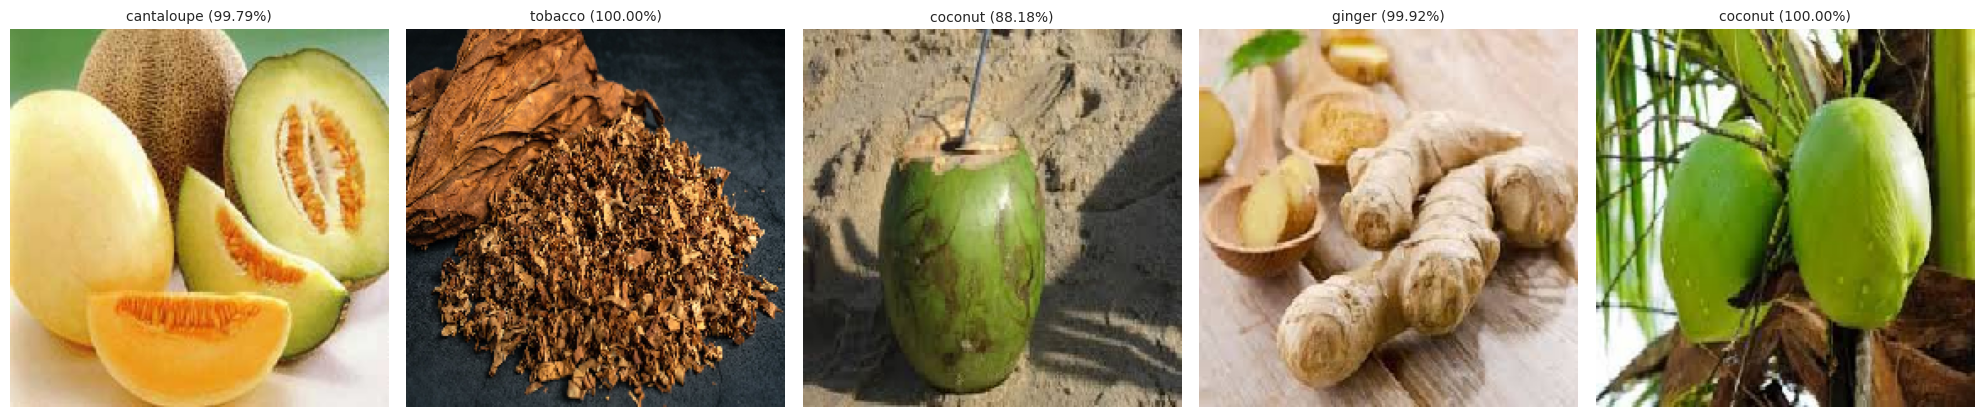

In [33]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from keras.layers import TFSMLayer

# Path ke folder test
test_dir = '/content/newplants_dataset'

# Mengambil semua path gambar beserta labelnya
img_paths = []
class_labels = []

for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
    if os.path.isdir(class_path):
        for img_file in os.listdir(class_path):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_paths.append(os.path.join(class_path, img_file))
                class_labels.append(class_name)

# Mengambil 5 sampel acak
sample_indices = random.sample(range(len(img_paths)), 5)
sample_paths = [img_paths[i] for i in sample_indices]
sample_true_labels = [class_labels[i] for i in sample_indices]

# Load model
model = TFSMLayer("saved_model", call_endpoint="serving_default")

class_map = list(train_generator.class_indices.keys())

# Untuk menyimpan hasil
sample_images = []
sample_pred_labels = []
sample_confidences = []

# Prediksi dan proses gambar
for img_path in sample_paths:
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Predict
    output = model(img_array, training=False)
    output_tensor = output["output_0"].numpy()

    predicted_index = np.argmax(output_tensor[0])
    predicted_label = class_map[predicted_index]
    confidence = output_tensor[0][predicted_index] * 100

    sample_images.append(img)
    sample_pred_labels.append(f"{predicted_label} ({confidence:.2f}%)")

# Menampilkan gambar
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i in range(5):
    ax = axes[i]
    ax.imshow(sample_images[i])
    ax.axis('off')
    ax.set_title(sample_pred_labels[i], fontsize=10)

plt.tight_layout()
plt.show()


In [32]:
!pip freeze requirements.txt

absl-py==1.4.0
accelerate==1.6.0
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.23
albumentations==2.0.5
ale-py==0.10.2
altair==5.5.0
annotated-types==0.7.0
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.1
arviz==0.21.0
astropy==7.0.1
astropy-iers-data==0.2025.4.21.0.37.6
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
backports.tarfile==1.2.0
beautifulsoup4==4.13.4
betterproto==2.0.0b6
bigframes==2.1.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blosc2==3.3.1
bokeh==3.7.2
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
CacheControl==0.14.2
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.1.31
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.1
chex==0.1.89
clarabel==0.10.0
click==8.1.8
cloudpathlib==0.21.0
cloudpickle==3.1.1
cmake==3.31.6
cmdstanpy==1.2.5
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confect